# UNSW DataThon 2018
Sean and lmcmz Submition

## Input all the package we needed

In [1]:
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats.stats import pearsonr as pr
from scipy.stats import ttest_ind as ttest
from  scipy.stats import f_oneway as aov
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Read the csv file and Pre-processing

In [2]:
userDf = pd.read_csv("User Data.csv")
bookDf = pd.read_csv("Books Information.csv")
prediction = pd.read_csv("output.csv")

#rename for coding
userDf.columns=["ID","User_Diff","B_17","B_18","Rate_17"]
bookDf.columns=["ID","Genre","Barcode","Diff","N_W","P_17","P_18","Place","N_S"]

userDf["R_18"]=prediction["Average Rating (2018)"]
# Convert the book strings into a list 
def convert2list(x):
    bookList=x.replace(" ","").split(",")
    return [int(i) for i in bookList]

userDf["B_17"] = userDf["B_17"].apply(convert2list)
userDf["B_18"] = userDf["B_18"].apply(convert2list)

## Calculate the mean of Rate in 2017 and 2018 for each book

In [3]:
def dict17Append(x):
    for i in x["B_17"]:
        book17Dict[i].append(x['Rate_17'])
book17Dict=defaultdict(list)
userDf.apply(dict17Append, axis=1)

def dict18Append(x):
    for i in x["B_18"]:
        book18Dict[i].append(x['R_18'])
book18Dict=defaultdict(list)
userDf.apply(dict18Append, axis=1)

def canvort2mean(bookDict):
    return {book:np.mean(rates) for book,rates in bookDict.items()}
book17Mean=canvort2mean(book17Dict)
book18Mean=canvort2mean(book18Dict)

bookDf["R_17"]=bookDf["ID"].apply(lambda x: book17Mean[x])
bookDf["R_18"]=bookDf["ID"].apply(lambda x: book18Mean[x])

bookDf.to_csv("bookRate.csv",index=False)

## Statistical analysis

In [4]:
def cal_aov(feature,target,df):
    feature_set=set(df[feature].values.tolist())
    diff_values=[]
    for i in feature_set:
        values=df[df[feature]==i][target].tolist() 
        diff_values.append(values)
    stat,p=aov(*diff_values)
    return stat,p

cate_features=["Genre","Diff","Place"]
for f in cate_features:
    st,p=cal_aov(f,"R_17",bookDf)
    print("{} vs {}".format(f,"Rate 2017"))
    print("Stat: {} \nP value: {}\n".format(round(st,4),round(p,4)))
    st,p=cal_aov(f,"R_18",bookDf)
    print("{} vs {}".format(f,"Rate 2018"))
    print("Stat: {} \nP value: {}\n".format(round(st,4),round(p,4)))
    st,p=cal_aov(f,"N_S",bookDf)
    print("{} vs {}".format(f,"Number Sold"))
    print("Stat: {} \nP value: {}\n".format(round(st,4),round(p,4)))
    
quantitive_features=["N_W","P_17","P_18",'N_S']
for f in quantitive_features:
    s,p=pr(bookDf[f],bookDf["R_17"])
    print("{} vs {}".format(f,"Rate 2017"))
    print("Stat: {} \nP value: {}\n".format(round(s,4),round(p,4)))
    s,p=pr(bookDf[f],bookDf["R_18"])
    print("{} vs {}".format(f,"Rate 2018"))
    print("Stat: {} \nP value: {}\n".format(round(s,4),round(p,4)))
    s,p=pr(bookDf[f],bookDf['N_S'])
    print("{} vs {}".format(f,"Number Sold"))
    print("Stat: {} \nP value: {}\n".format(round(s,4),round(p,4)))

Genre vs Rate 2017
Stat: 2.1154 
P value: 0.0004

Genre vs Rate 2018
Stat: 2.6372 
P value: 0.0

Genre vs Number Sold
Stat: 1.1746 
P value: 0.2356

Diff vs Rate 2017
Stat: 0.4266 
P value: 0.7895

Diff vs Rate 2018
Stat: 0.358 
P value: 0.8386

Diff vs Number Sold
Stat: 2.1516 
P value: 0.072

Place vs Rate 2017
Stat: 1.509 
P value: 0.1968

Place vs Rate 2018
Stat: 0.5103 
P value: 0.7282

Place vs Number Sold
Stat: 0.9382 
P value: 0.4407

N_W vs Rate 2017
Stat: 0.0065 
P value: 0.721

N_W vs Rate 2018
Stat: 0.0132 
P value: 0.4711

N_W vs Number Sold
Stat: 0.0113 
P value: 0.5348

P_17 vs Rate 2017
Stat: -0.0047 
P value: 0.7976

P_17 vs Rate 2018
Stat: -0.0073 
P value: 0.6895

P_17 vs Number Sold
Stat: 0.0204 
P value: 0.2645

P_18 vs Rate 2017
Stat: -0.0045 
P value: 0.8046

P_18 vs Rate 2018
Stat: -0.0083 
P value: 0.6478

P_18 vs Number Sold
Stat: 0.0197 
P value: 0.2812

N_S vs Rate 2017
Stat: 0.0054 
P value: 0.768

N_S vs Rate 2018
Stat: 0.0073 
P value: 0.6896

N_S vs Numb

## Generate the dictionary for mapping the words

In [6]:
wordM=pd.read_csv("Words Mapping.csv")
wordDict={}
def addWordDict(x):
	wordDict[x["Word ID"]]=x["Word"]
t=wordM.apply(addWordDict,axis=1)

## Change the format of words into one-hot 

In [7]:
df=pd.read_csv("Words in Books Data.csv")
bookRateDf=pd.read_csv("bookRate.csv")
sp_l=lambda x: np.array(x.split("|"),dtype=int)
WordsList=df["Words in Book"].apply(sp_l).tolist()
counter = CountVectorizer(lowercase = False, tokenizer = lambda x: x)
X= counter.fit_transform(WordsList)
countArray=X.toarray()

## Apply t-test for word selections

In [8]:
def calTtest(work,y):
    y=np.array(y)
    tID=np.where(countArray[:,work]>0)
    fID=np.where(countArray[:,work]==0)
    ty=y[tID]
    fy=y[fID]
    return ttest(*[ty,fy])

diffDict={17:[],
          18:[]}
for index in range(8234):
    for y in [17,18]:
        stat,p=calTtest(index,bookRateDf["R_"+str(y)])
        if p<0.05:
            diffDict[y].append(index)

G:\py\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
G:\py\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\py\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
G:\py\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
G:\py\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


#### 270 words in 2017 are seleceted for the following steps and the data is saved into a csv file and the rest analysis is using R to select the most important words.

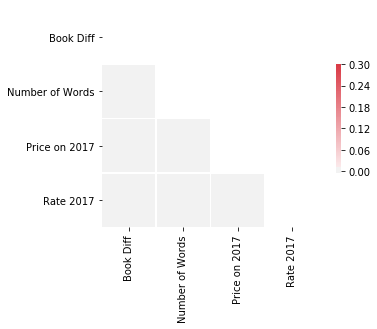

In [9]:
selectedDF=bookDf[["Diff","N_W","P_17","R_17"]]
selectedDF.columns=["Book Diff","Number of Words","Price on 2017","Rate 2017"]
corr=selectedDF.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
